In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
import json
from pandas import json_normalize

with open('C:\\user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

df = json_normalize(data)

In [3]:
df.columns

Index(['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp',
       'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type',
       'actionData.amount', 'actionData.assetSymbol',
       'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId',
       'createdAt.$date', 'updatedAt.$date', 'actionData.toId',
       'actionData.borrowRateMode', 'actionData.borrowRate',
       'actionData.variableTokenDebt', 'actionData.stableTokenDebt',
       'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId',
       'actionData.liquidatorId', 'actionData.collateralAmount',
       'actionData.collateralAssetPriceUSD', 'actionData.principalAmount',
       'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId',
       'actionData.collateralReserveSymbol', 'actionData.principalReserveId',
       'actionData.principalReserveSymbol'],
      dtype='object')

In [4]:
# Renaming columns for clarity
df.rename(columns={'userWallet': 'wallet',
                   'actionData.amount': 'amount',
                   'actionData.assetSymbol': 'asset',
                   'actionData.assetPriceUSD': 'asset_priceUsd'}, inplace=True)


In [5]:
# Converting columns to appropriate types, removing columns that have nil values
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['amount'] = df['amount'].fillna(0)
df['asset_priceUsd'] = pd.to_numeric(df['asset_priceUsd'], errors='coerce')
df['asset_priceUsd'] = df['asset_priceUsd'].fillna(0)
df['amount_usd'] = df['amount'] * df['asset_priceUsd']
df['asset'] = df['asset'].astype(str).fillna('UNKNOWN_ASSET')
df['action'] = df['action'].astype(str).fillna('UNKNOWN_ACTION')
df['wallet'] = df['wallet'].astype(str)


In [6]:
# Dropping unnecessary columns that don't contribute to the analysis
Dropped_columns = [
    '__v', '_id.$oid', 'txHash', 'logId',
    'network', 'protocol',
    'createdAt.$date', 'updatedAt.$date',
    'blockNumber',
    'actionData.type',
    'actionData.poolId', 'actionData.userId',
    'actionData.toId',
    'actionData.borrowRateMode',
    'actionData.borrowRate',
    'actionData.variableTokenDebt',
    'actionData.stableTokenDebt',
    'actionData.callerId',
    'actionData.useATokens',
    'actionData.repayerId',
    'actionData.liquidatorId',
    'actionData.collateralAmount',
    'actionData.collateralAssetPriceUSD',
    'actionData.principalAmount',
    'actionData.borrowAssetPriceUSD',
    'actionData.collateralReserveId', 'actionData.collateralReserveSymbol',
    'actionData.principalReserveId', 'actionData.principalReserveSymbol'
]
Dropped_columns = [col for col in Dropped_columns if col in df.columns]
df.drop(columns=Dropped_columns, errors='ignore', inplace=True)

In [7]:
# Feature engineering by grouping by wallet and action
wallet_grouped = df.groupby('wallet').agg(
    total_transactions=('wallet', 'size'),
    first_transaction_time=('timestamp', 'min'),
    last_transaction_time=('timestamp', 'max'),
    num_unique_assets=('asset', 'nunique'),
    total_deposited_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'deposit'].sum()),
    num_deposits=('action', lambda x: (x == 'deposit').sum()),
    largest_single_deposit_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'deposit'].max()),
    total_borrowed_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'borrow'].sum()),
    num_borrows=('action', lambda x: (x == 'borrow').sum()),
    largest_single_borrow_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'borrow'].max()),
    total_repaid_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'repay'].sum()),
    num_repays=('action', lambda x: (x == 'repay').sum()),
    total_redeemed_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'redeemunderlying'].sum()),
    num_redeems=('action', lambda x: (x == 'redeemunderlying').sum()),
    num_liquidation_calls=('action', lambda x: (x == 'liquidationcall').sum()),
    total_liquidated_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'liquidationcall'].sum()),
).reset_index()

for col in ['largest_single_deposit_usd', 'largest_single_borrow_usd']:
    wallet_grouped[col] = wallet_grouped[col].fillna(0)

wallet_features_df = wallet_grouped.copy()


In [8]:
# Feature Engineering
wallet_features_df['days_active'] = (wallet_features_df['last_transaction_time'] - wallet_features_df['first_transaction_time']).dt.days
wallet_features_df['days_active'] = wallet_features_df['days_active'].apply(lambda x: 1 if x == 0 else x)
wallet_features_df['transaction_frequency'] = wallet_features_df['total_transactions'] / wallet_features_df['days_active']
wallet_features_df['avg_deposit_usd'] = np.where(wallet_features_df['num_deposits'] > 0, wallet_features_df['total_deposited_usd'] / wallet_features_df['num_deposits'], 0)
wallet_features_df['avg_borrow_usd'] = np.where(wallet_features_df['num_borrows'] > 0, wallet_features_df['total_borrowed_usd'] / wallet_features_df['num_borrows'], 0)
wallet_features_df['avg_repay_usd'] = np.where(wallet_features_df['num_repays'] > 0, wallet_features_df['total_repaid_usd'] / wallet_features_df['num_repays'], 0)
wallet_features_df['repay_to_borrow_ratio'] = np.where(wallet_features_df['total_borrowed_usd'] > 0, wallet_features_df['total_repaid_usd'] / wallet_features_df['total_borrowed_usd'], 1.0)
wallet_features_df['repay_to_borrow_ratio'] = wallet_features_df['repay_to_borrow_ratio'].clip(upper=5.0)
wallet_features_df['avg_redeem_usd'] = np.where(wallet_features_df['num_redeems'] > 0, wallet_features_df['total_redeemed_usd'] / wallet_features_df['num_redeems'], 0)
wallet_features_df['deposit_to_redeem_ratio'] = np.where(wallet_features_df['total_redeemed_usd'] > 0, wallet_features_df['total_deposited_usd'] / wallet_features_df['total_redeemed_usd'], wallet_features_df['total_deposited_usd'] + 1000)
wallet_features_df['deposit_to_redeem_ratio'] = wallet_features_df['deposit_to_redeem_ratio'].clip(upper=1000.0)
wallet_features_df['has_been_liquidated'] = (wallet_features_df['num_liquidation_calls'] > 0).astype(int)
wallet_features_df['net_flow_usd'] = (wallet_features_df['total_deposited_usd'] + wallet_features_df['total_repaid_usd'] - wallet_features_df['total_borrowed_usd'] - wallet_features_df['total_redeemed_usd'] - wallet_features_df['total_liquidated_usd'])
wallet_features_df['borrow_to_deposit_ratio_overall'] = np.where(wallet_features_df['total_deposited_usd'] > 0, wallet_features_df['total_borrowed_usd'] / wallet_features_df['total_deposited_usd'], np.where(wallet_features_df['total_borrowed_usd'] > 0, 100.0, 0.0))
wallet_features_df['borrow_to_deposit_ratio_overall'] = wallet_features_df['borrow_to_deposit_ratio_overall'].clip(upper=100.0)
wallet_features_df['current_net_borrowed_balance_usd'] = wallet_features_df['total_borrowed_usd'] - wallet_features_df['total_repaid_usd']



In [9]:
temp_df_deposit = df[df['action'] == 'deposit'].groupby('wallet')['amount_usd'].std().reset_index()
temp_df_deposit.rename(columns={'amount_usd': 'deposit_volatility_usd'}, inplace=True)
wallet_features_df = pd.merge(wallet_features_df, temp_df_deposit, on='wallet', how='left')
temp_df_borrow = df[df['action'] == 'borrow'].groupby('wallet')['amount_usd'].std().reset_index()
temp_df_borrow.rename(columns={'amount_usd': 'borrow_volatility_usd'}, inplace=True)
wallet_features_df = pd.merge(wallet_features_df, temp_df_borrow, on='wallet', how='left')
temp_df_repay = df[df['action'] == 'repay'].groupby('wallet')['amount_usd'].std().reset_index()
temp_df_repay.rename(columns={'amount_usd': 'repay_volatility_usd'}, inplace=True)
wallet_features_df = pd.merge(wallet_features_df, temp_df_repay, on='wallet', how='left')
temp_df_redeem = df[df['action'] == 'redeemunderlying'].groupby('wallet')['amount_usd'].std().reset_index()
temp_df_redeem.rename(columns={'amount_usd': 'redeem_volatility_usd'}, inplace=True)
wallet_features_df = pd.merge(wallet_features_df, temp_df_redeem, on='wallet', how='left')

for col in ['deposit_volatility_usd', 'borrow_volatility_usd', 'repay_volatility_usd', 'redeem_volatility_usd']:
    wallet_features_df[col] = wallet_features_df[col].fillna(0)

In [10]:
# Calculating proxy_scores
def calculate_proxy_score(features_df):
    proxy_scores = pd.Series(0.0, index=features_df.index) #Starting at 0 and then further building the score

    # 1. Payment History, contribution 350 points
    repay_ratio = features_df['repay_to_borrow_ratio'].clip(upper=1.0)
    proxy_scores += repay_ratio * 350
    proxy_scores -= features_df['num_liquidation_calls'] * 150
    proxy_scores -= features_df['has_been_liquidated'] * 100

    # Credit utilization 300 points
    proxy_scores += 300
    penalty_rate = features_df['borrow_to_deposit_ratio_overall'].clip(upper=2.0)
    proxy_scores -= penalty_rate * 150

    # 3. Length of Credit History, 150 points
    max_days= features_df['days_active'].max()
    effective_days = max(max_days, 365)
    length = (features_df['days_active'] / effective_days).clip(upper=1.0)
    proxy_scores += length * 150

    # 4. New Credit 100 points
    total_tx = features_df['total_transactions'].max()
    effective_max_tx = max(total_tx, 100)
    new_credit = (np.sqrt(features_df['total_transactions']) / np.sqrt(effective_max_tx)).clip(upper=1.0)
    proxy_scores += new_credit * 100

    # 5. Credit Mix 100 points
    unique_assets = features_df['num_unique_assets'].max()
    effective_max_assets = max(unique_assets, 5)
    mix = (features_df['num_unique_assets'] / effective_max_assets).clip(upper=1.0)
    proxy_scores += mix * 100

    # Overall Financial Health 
    netflow_positive = np.log1p(features_df['net_flow_usd'].clip(lower=0))
    if netflow_positive.max() > 0:
        netflow_positive_scaled = (netflow_positive / netflow_positive.max()).clip(upper=1.0)
        proxy_scores += netflow_positive_scaled * 100
    proxy_scores += np.where(features_df['net_flow_usd'] < 0, features_df['net_flow_usd'] * 0.02, 0)

    proxy_scores = proxy_scores.clip(lower=0, upper=1000)

    return proxy_scores


In [11]:
y = calculate_proxy_score(wallet_features_df) # Defininig target variabke

In [12]:
# Calculating feature matrix X and target variable y
X = wallet_features_df.drop(columns=['wallet', 'first_transaction_time', 'last_transaction_time'])
X = X.fillna(0)
wallets_index = wallet_features_df['wallet']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # Splitting the dataset into training and testing sets

In [14]:
# Feature Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
feature_names = X.columns.tolist()

In [15]:
# Evaluation
def evaluate_model(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test, model_obj=None, feature_names=None):
    print(f"\n--- {model_name} Performance ---")
    print(f"R-squared (Train): {r2_score(y_true_train, y_pred_train):.4f}")
    print(f"R-squared (Test): {r2_score(y_true_test, y_pred_test):.4f}")
    print(f"MAE (Train): {mean_absolute_error(y_true_train, y_pred_train):.2f}")
    print(f"MAE (Test): {mean_absolute_error(y_true_test, y_pred_test):.2f}")
    print(f"RMSE (Train): {np.sqrt(mean_squared_error(y_true_train, y_pred_train)):.2f}")
    print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_true_test, y_pred_test)):.2f}")

    if model_obj and hasattr(model_obj, 'feature_importances_') and feature_names:
        feature_importances = pd.Series(model_obj.feature_importances_, index=feature_names)
        sorted_importances = feature_importances.sort_values(ascending=False)
        print("\nFeature Importances (Top 10)")
        print(sorted_importances.head(10))
    elif model_obj and hasattr(model_obj, 'coef_') and feature_names:
        coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': model_obj.coef_})
        coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
        coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')
        print("\nCoefficients (Top 10)")
        print(coefficients.head(10))

In [16]:
# Training Random Forest Regressor Model
print("\nTraining Random Forest Regressor Model")
rf_model = RandomForestRegressor(
    n_estimators=500,     
    max_depth=75,        
    min_samples_split=5, 
    min_samples_leaf=3,   
    random_state=42,
    n_jobs=-1             
)
rf_model.fit(X_train_scaled, y_train) 

# Predict and Evaluate
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)
evaluate_model("Random Forest Regressor", y_train, y_pred_rf_train, y_test, y_pred_rf_test, rf_model, feature_names)


Training Random Forest Regressor Model

--- Random Forest Regressor Performance ---
R-squared (Train): 0.9892
R-squared (Test): 0.9714
MAE (Train): 8.27
MAE (Test): 12.23
RMSE (Train): 29.55
RMSE (Test): 47.09

Feature Importances (Top 10)
deposit_to_redeem_ratio            0.611981
repay_to_borrow_ratio              0.248211
net_flow_usd                       0.052749
num_liquidation_calls              0.018477
borrow_to_deposit_ratio_overall    0.012098
has_been_liquidated                0.011501
num_unique_assets                  0.006863
total_transactions                 0.005965
avg_deposit_usd                    0.004977
days_active                        0.004462
dtype: float64


In [17]:
print("\nTraining Ridge Regression Model")
ridge_model = Ridge(alpha=2.0, random_state=42) # alpha can be tuned later
ridge_model.fit(X_train_scaled, y_train)

# Predict and Evaluate
y_pred_ridge_train = ridge_model.predict(X_train_scaled)
y_pred_ridge_test = ridge_model.predict(X_test_scaled)
evaluate_model("Ridge Regression", y_train, y_pred_ridge_train, y_test, y_pred_ridge_test, ridge_model, feature_names)


Training Ridge Regression Model

--- Ridge Regression Performance ---
R-squared (Train): 0.4365
R-squared (Test): -21.3427
MAE (Train): 151.00
MAE (Test): 194.66
RMSE (Train): 213.84
RMSE (Test): 1315.47

Coefficients (Top 10)
                            Feature  Coefficient
21          deposit_to_redeem_ratio   158.453512
19            repay_to_borrow_ratio   111.568404
29            redeem_volatility_usd   -60.279747
1                 num_unique_assets    58.670116
24  borrow_to_deposit_ratio_overall   -52.866151
3                      num_deposits    48.125226
22              has_been_liquidated   -45.675379
11                      num_redeems   -41.427985
20                   avg_redeem_usd    35.820498
7         largest_single_borrow_usd   -34.463466


In [18]:
# Model MLP regressor
print("\nTraining MLP Regressor Model")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    verbose=False,
    tol=1e-4
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)
evaluate_model("MLP Regressor", y_train, y_pred_mlp_train, y_test, y_pred_mlp_test, mlp_model, feature_names)


Training MLP Regressor Model

--- MLP Regressor Performance ---
R-squared (Train): 0.6746
R-squared (Test): 0.4913
MAE (Train): 95.23
MAE (Test): 100.22
RMSE (Train): 162.50
RMSE (Test): 198.49


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
# Model XG Booster
!pip install xgboost --quiet
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model("XG Booster", y_train, y_pred_mlp_train, y_test, y_pred_mlp_test, xgb_model, feature_names)


--- XG Booster Performance ---
R-squared (Train): 0.6746
R-squared (Test): 0.4913
MAE (Train): 95.23
MAE (Test): 100.22
RMSE (Train): 162.50
RMSE (Test): 198.49

Feature Importances (Top 10)
net_flow_usd                        0.486527
repay_to_borrow_ratio               0.230609
num_liquidation_calls               0.100878
has_been_liquidated                 0.094256
deposit_to_redeem_ratio             0.051192
borrow_to_deposit_ratio_overall     0.009065
num_unique_assets                   0.006417
current_net_borrowed_balance_usd    0.004261
days_active                         0.002529
num_repays                          0.001884
dtype: float32


In [20]:
output_scaler = MinMaxScaler(feature_range=(0, 1000))
output_scaler.fit(y_train.values.reshape(-1, 1))

MinMaxScaler(feature_range=(0, 1000))

In [21]:
final_model = rf_model

In [22]:
all_scaled = scaler_X.transform(X) 
wallet_scores = final_model.predict(all_scaled)

In [23]:
scaled_scores = output_scaler.transform(wallet_scores.reshape(-1, 1)).flatten()


In [24]:
final_scores = pd.Series(scaled_scores, index=wallets_index).round().astype(int)

In [25]:
print("\nSample of Final Predicted Wallet Scores (0-1000)")
print(final_scores.head(10)) 
print(f"\nTotal wallets scored: {len(final_scores)}")


Sample of Final Predicted Wallet Scores (0-1000)
wallet
0x00000000001accfa9cef68cf5371a23025b6d4b6    791
0x000000000051d07a4fb3bd10121a343d85818da6    852
0x000000000096026fb41fc39f9875d164bd82e2dc    794
0x0000000000e189dd664b9ab08a33c4839953852c      0
0x0000000002032370b971dabd36d72f3e5a7bf1ee    552
0x000000000a38444e0a6e37d3b630d7e855a7cb13    925
0x000000003853fcedcd0355fec98ca3192833f00b    877
0x000000003ce0cf2c037493b1dc087204bd7f713e    574
0x000000007858e6f2668e1e06111cfa24403a5466    837
0x00000001a0f57e850c9db68b4a9bc34677437c5c    791
dtype: int32

Total wallets scored: 3497


In [26]:
#Saving the Chosen Model and Scalers 
joblib.dump(final_model, 'credit_score_model.joblib') 
joblib.dump(scaler_X, 'feature_scaler_X.joblib')     
joblib.dump(output_scaler, 'output_scaler_Y.joblib') 
joblib.dump(feature_names, 'feature_names.joblib') 

['feature_names.joblib']

In [44]:
final_scores = pd.Series(scaled_scores, index=wallets_index).round().astype(int)

In [45]:
import json
output_scores_dict = final_scores.to_dict()
with open("wallet_scores.json", "w") as f:
    json.dump(output_scores_dict, f, indent=4)
print("wallet_scores.json saved.")

wallet_scores.json saved.


In [46]:
images_folder = 'C:\\Users\\hp\\Downloads\\New folder\\Machine learning\\Images'
import os
os.makedirs(images_folder, exist_ok=True)

In [51]:
wallet_features_df['final_credit_score'] = final_scores
final_wallet_scores_df = final_scores.rename('final_credit_score').reset_index()
final_wallet_scores_df.rename(columns={'index': 'wallet'}, inplace=True) 
wallet_features_df = pd.merge(wallet_features_df, final_wallet_scores_df, on='wallet', how='left')

In [52]:
wallet_features_df.info(
    )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wallet                            3497 non-null   object        
 1   total_transactions                3497 non-null   int64         
 2   first_transaction_time            3497 non-null   datetime64[ns]
 3   last_transaction_time             3497 non-null   datetime64[ns]
 4   num_unique_assets                 3497 non-null   int64         
 5   total_deposited_usd               3497 non-null   float64       
 6   num_deposits                      3497 non-null   int64         
 7   largest_single_deposit_usd        3497 non-null   float64       
 8   total_borrowed_usd                3497 non-null   float64       
 9   num_borrows                       3497 non-null   int64         
 10  largest_single_borrow_usd         3497 non-null 

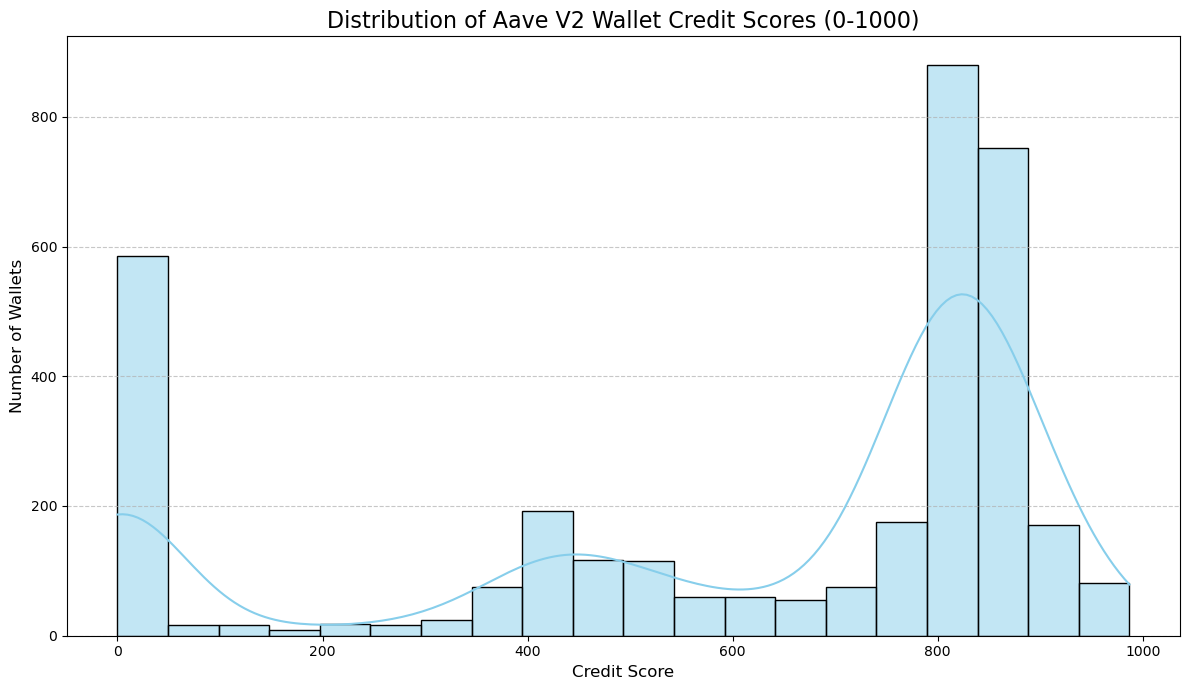

Score distribution plot saved to 'images/score_distribution.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 7))
sns.histplot(wallet_features_df['final_credit_score_y'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Aave V2 Wallet Credit Scores (0-1000)', fontsize=16)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(images_folder, 'score_distribution.png'))
plt.show()



Feature Importance Plot


C:\Users\hp\AppData\Local\Temp\ipykernel_13740\4145390246.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')


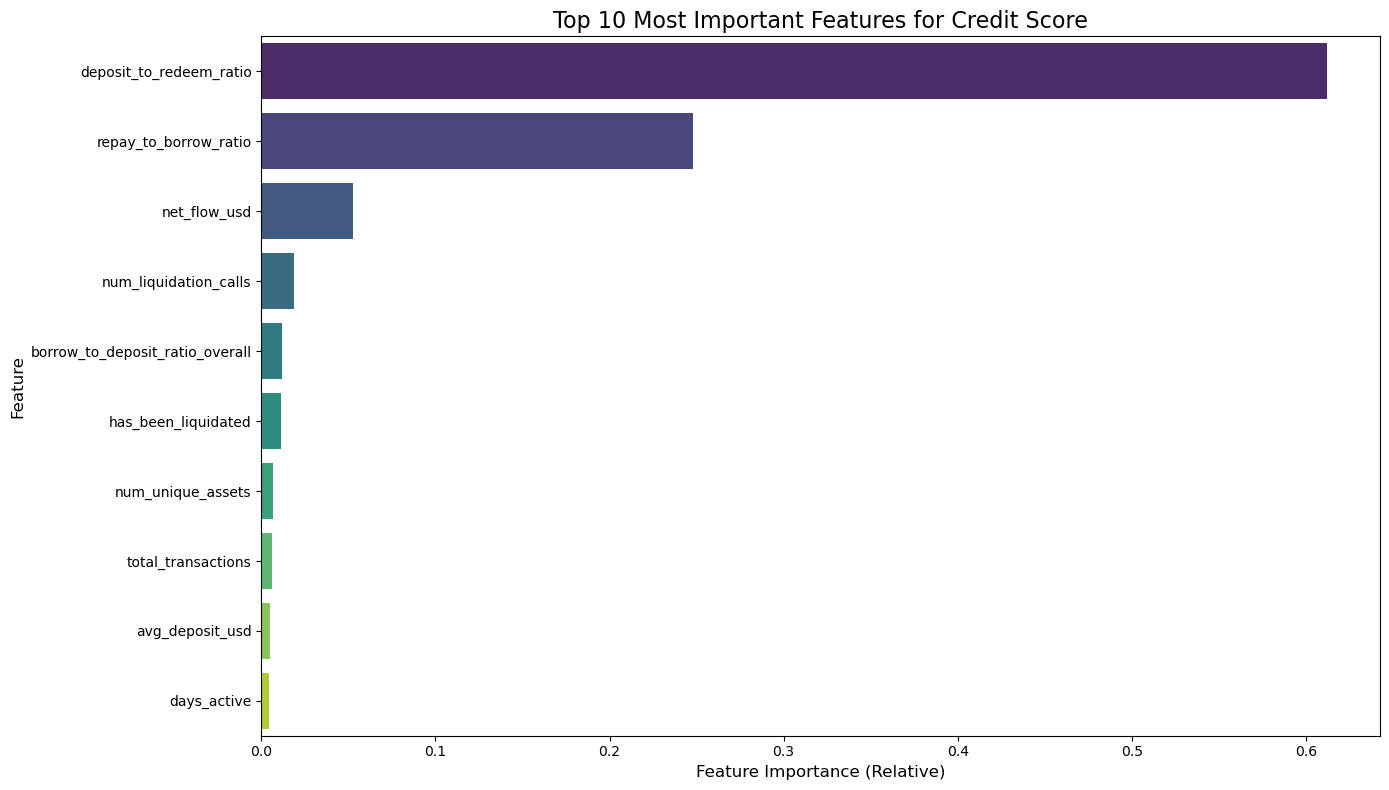


Top 10 Feature Importances (Values):
deposit_to_redeem_ratio            0.611981
repay_to_borrow_ratio              0.248211
net_flow_usd                       0.052749
num_liquidation_calls              0.018477
borrow_to_deposit_ratio_overall    0.012098
has_been_liquidated                0.011501
num_unique_assets                  0.006863
total_transactions                 0.005965
avg_deposit_usd                    0.004977
days_active                        0.004462
dtype: float64


In [58]:
print("\nFeature Importance Plot")
feature_importances = pd.Series(rf_model.feature_importances_, index=feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')
plt.title('Top 10 Most Important Features for Credit Score', fontsize=16)
plt.xlabel('Feature Importance (Relative)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(images_folder, 'feature_importances.png'))
plt.show()

print("\nTop 10 Feature Importances (Values):")
print(sorted_importances.head(10))


Generating Behavioral Insight Plots.


C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='viridis')


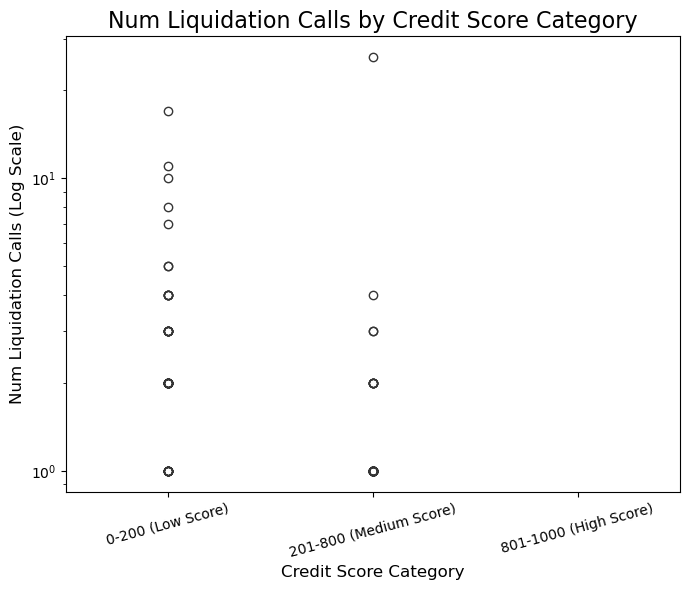

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


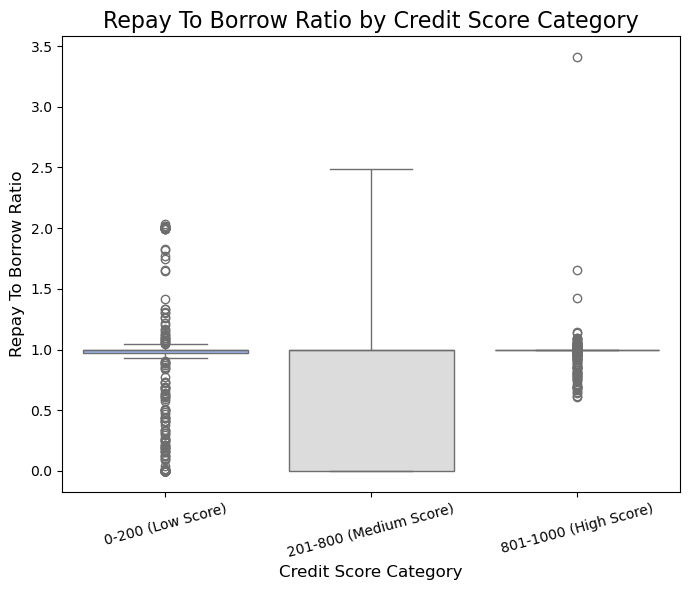

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


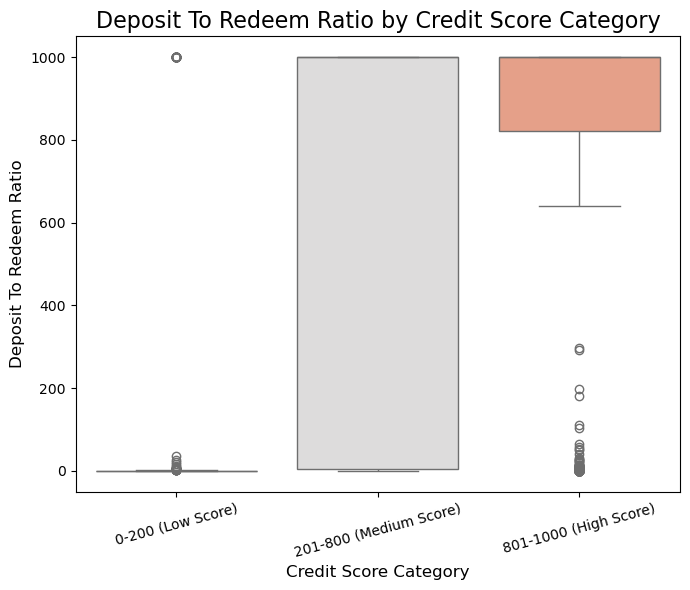

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


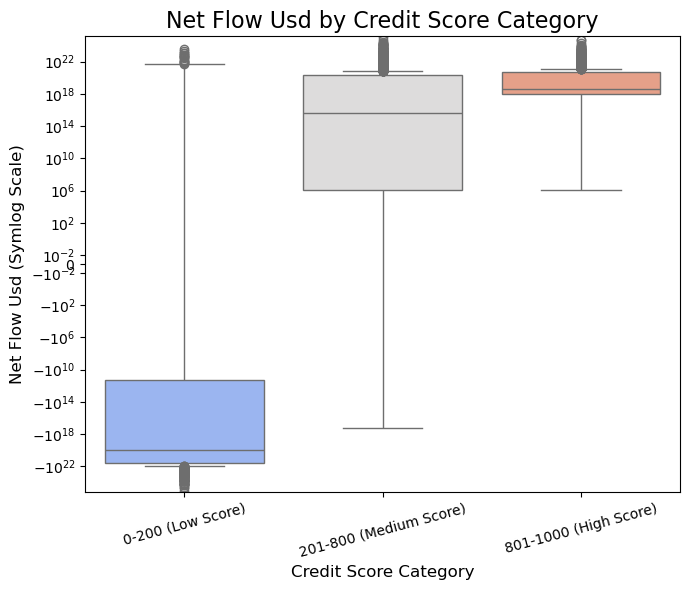

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


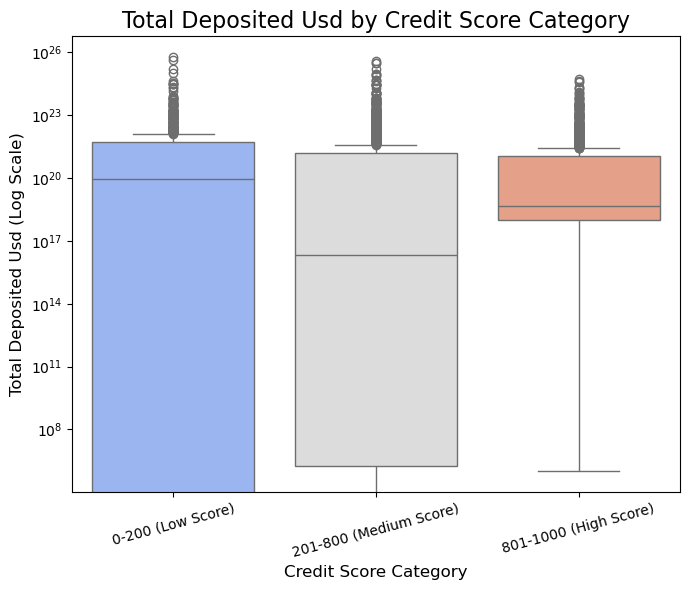

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


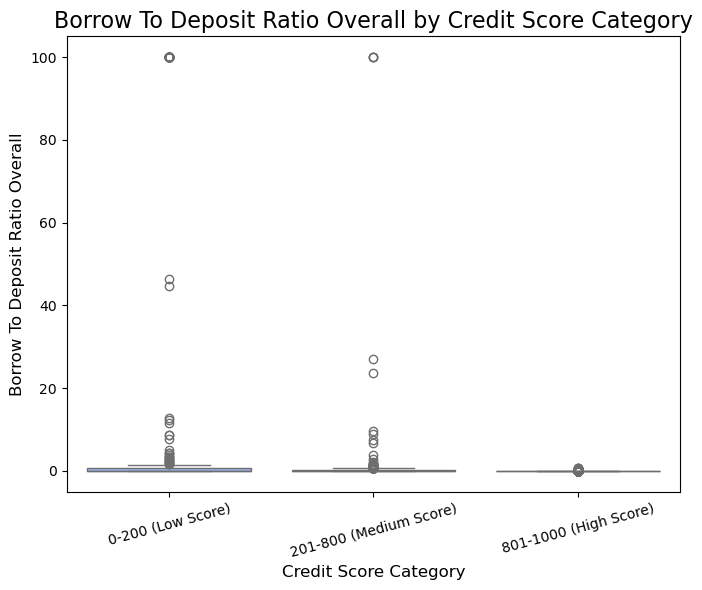

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


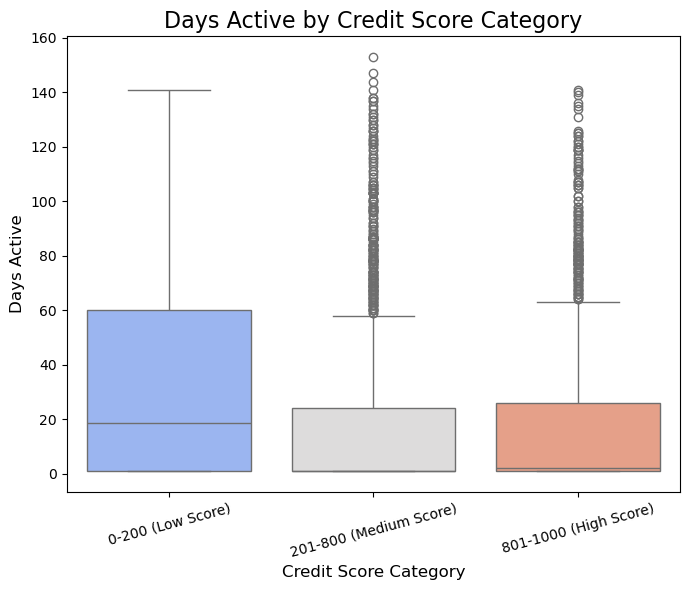

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')


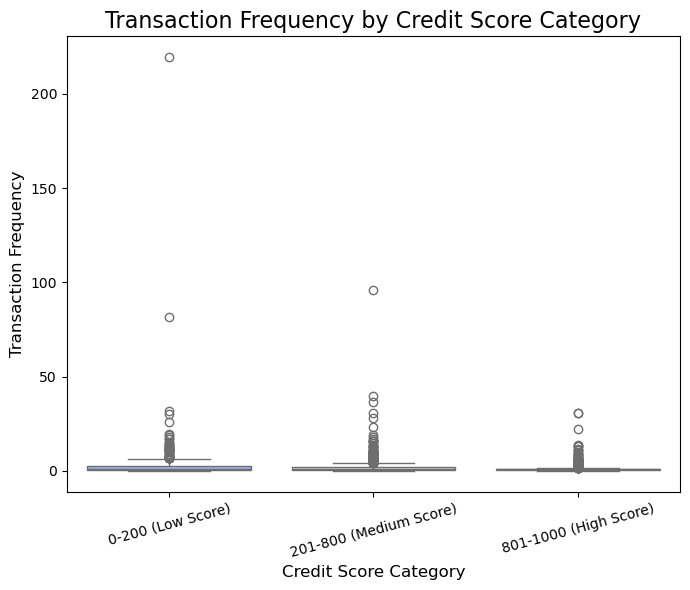

C:\Users\hp\AppData\Local\Temp\ipykernel_13740\551178188.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_categories_data = wallet_features_df.groupby('score_category')[key_behavioral_features].mean()


                        num_liquidation_calls  repay_to_borrow_ratio  deposit_to_redeem_ratio  net_flow_usd  total_deposited_usd  borrow_to_deposit_ratio_overall  days_active  transaction_frequency
score_category                                                                                                                                                                                       
0-200 (Low Score)                    0.257143               0.866770                56.403907 -7.223629e+22         2.666776e+23                         7.657981    33.417460               2.744493
201-800 (Medium Score)               0.053218               0.614455               688.227440  2.767255e+22         1.327621e+23                         0.402208    19.264851               1.853099
801-1000 (High Score)                0.000000               0.995499               752.207228  1.865513e+22         3.105607e+22                         0.024365    19.948841               1.314138


In [63]:
wallet_features_df['score_category'] = pd.cut(
    wallet_features_df['final_credit_score_y'],
    bins=[0, 200, 800, 1000], 
    labels=['0-200 (Low Score)', '201-800 (Medium Score)', '801-1000 (High Score)'],
    right=False 
)
key_behavioral_features = [
    'num_liquidation_calls',
    'repay_to_borrow_ratio',
    'deposit_to_redeem_ratio',
    'net_flow_usd',
    'total_deposited_usd',
    'borrow_to_deposit_ratio_overall',
    'days_active',
    'transaction_frequency',
]
print("\nGenerating Behavioral Insight Plots.")

for feature in key_behavioral_features:
    plt.figure(figsize=(7, 6))
    if feature in ['num_liquidation_calls', 'total_deposited_usd', 'net_flow_usd', 'current_net_borrowed_balance_usd']:
        if feature == 'num_liquidation_calls':
            sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='viridis')
            plt.yscale('log') 
            plt.ylabel(f'{feature.replace("_", " ").title()} (Log Scale)', fontsize=12)
        elif feature == 'net_flow_usd':
            
             sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')
             plt.yscale('symlog', linthresh=0.01) 
             plt.ylabel(f'{feature.replace("_", " ").title()} (Symlog Scale)', fontsize=12)
        else: 
            sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')
            plt.yscale('log')
            plt.ylabel(f'{feature.replace("_", " ").title()} (Log Scale)', fontsize=12)
    else: 
        sns.boxplot(x='score_category', y=feature, data=wallet_features_df, palette='coolwarm')
        plt.ylabel(f'{feature.replace("_", " ").title()}', fontsize=12)
    
    plt.title(f'{feature.replace("_", " ").title()} by Credit Score Category', fontsize=16)
    plt.xlabel('Credit Score Category', fontsize=12)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(images_folder, f'behavioral_boxplot_{feature}.png'))
    plt.show()
score_categories_data = wallet_features_df.groupby('score_category')[key_behavioral_features].mean()
print(score_categories_data.to_string())

   


In [66]:
total_wallets = len(wallet_features_df)
low_score_wallets_count = len(wallet_features_df[wallet_features_df['final_credit_score_y'] <= 200])
high_score_wallets_count = len(wallet_features_df[wallet_features_df['final_credit_score_y'] >= 801])

percentage_low_score = (low_score_wallets_count / total_wallets) * 100
percentage_high_score = (high_score_wallets_count / total_wallets) * 100
percentage_middle_range = 100 - (percentage_low_score + percentage_high_score) 

print(f"Total Wallets: {total_wallets}")
print(f"Wallets with score 0-200: {low_score_wallets_count} ({percentage_low_score:.2f}%)")
print(f"Wallets with score 801-1000: {high_score_wallets_count} ({percentage_high_score:.2f}%)")
print(f"Wallets with score 201-800: {total_wallets - low_score_wallets_count - high_score_wallets_count} ({percentage_middle_range:.2f}%)")

Total Wallets: 3497
Wallets with score 0-200: 630 (18.02%)
Wallets with score 801-1000: 1250 (35.74%)
Wallets with score 201-800: 1617 (46.24%)
